# ---- RLAGN HERG/LERG CLASSIFICATION PIPELINE ----
- Data preparation, feature engineering, and Random Forest ML for RLAGN excitation mode  
- Based on SDSS DR7, Best & Heckman 2012/Janssen+2012, MPA-JHU value-added catalogs

In [87]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [88]:
import matplotlib.pyplot as plt
import math
import os
from astropy.io import fits, ascii
from astropy.table import Table, hstack, join
from astropy.stats import binom_conf_interval



## Data handling 

In [89]:
t0 = Table.read('data/gal_fnal_dr7_v5_2.fit.gz')

In gal_fnal_dr7_v5_2.fits.gz, there is a column named CMODEL which is a length‐5 array of SDSS. “CModel” magnitudes in the order 
[u,g,r,i,z]  
**Morphological features**  
Concentration index: 
R_90/R_50 (the radius containing 90% vs 50% of the galaxy’s light, from SDSS photometry)  
PETRO* quantities are reported separately for each band (u, g, r, i, z)  
I use the value from the r-band because it's least affected by young stars and dust.

In [90]:
plate =t0["PLATE"]
mjd   = t0["MJD"]
fiber = t0["FIBERID"]
cmodel= t0["CMODEL"]
R90_r = t0['PETROR90'][:, 2]  # PETROR90: shape (n_galaxies, 5) # Want r-band = index 2
R50_r =t0['PETROR50'][:, 2]  #PETROR50: shape (n_galaxies, 5)
u_mag = cmodel[:, 0]
g_mag = cmodel[:, 1]
r_mag = cmodel[:, 2]
i_mag = cmodel[:, 3]
z_mag = cmodel[:, 4]
phot = Table([plate,mjd, fiber, u_mag, g_mag, r_mag, i_mag, z_mag, R90_r ,R50_r], 
             names=("PLATEID","MJD", "FIBERID", "u_mag", "g_mag", "r_mag", "i_mag", "z_mag", "R90_r", "R50_r"))

In [91]:
tr = ascii.read('Table1.dat')  # Best & Heckman/Janssen RLAGN master table
column_mapping = {'col1': 'PLATEID', 'col2': 'MJD', 'col3': 'FIBERID','col4' :'ra' ,'col5': 'dec','col6' : 'redshift','col7' : 'SNVSS','col8':'RCl','col9':'SFIRST' ,'col11':'RLAGN','col12': 'main-sample','col13':'LERG','col14':'HERG'}
for old_name, new_name in column_mapping.items():
    tr.rename_column(old_name, new_name)
mask = tr['RLAGN'] == 1
bh201 = tr[mask]
bh2012 = bh201[["PLATEID","MJD", "FIBERID",'LERG','HERG']] # table lenght = 15300 all are RLAGN 
bh_clean = bh2012[(bh2012['LERG'] == 1) | (bh2012['HERG'] == 1)] # LERG = 9863, herg = 481,  9863 + 481 = 10344 are all agn with defined labels

In [92]:
t2 = Table.read('data/gal_info_dr7_v5_2.fit.gz')
info_df = t2[['PLATEID','MJD','FIBERID','Z']]

In [93]:
t3 = Table.read('data/totlgm_dr7_v5_2.fit.gz')
mass_df = t3[['AVG']]
#mass_df1= mass_df[mass_df['AVG'] > 8.0]

In [94]:
t4 = Table.read('data/gal_totsfr_dr7_v5_2.fits.gz')
sfr_df = t4[['AVG']]
#sfr_df= sfr_df[sfr_df['AVG'] > -10]

In [95]:
t5 = Table.read('data/gal_line_dr7_v5_2.fit.gz')
line_df = t5[['OIII_5007_FLUX', 'H_BETA_FLUX',
                      'NII_6584_FLUX', 'H_ALPHA_FLUX',
                      'SII_6717_FLUX', 'SII_6731_FLUX',  
                      'OI_6300_FLUX']]
# PLATEID', 'FIBERID',

In [96]:
t6 = Table.read('data/gal_indx_dr7_v5_2.fit')
d4000 = t6[['PLATEID', 'FIBERID', 'D4000_N']]
d4000_df = t6[['D4000_N']]

In [97]:
# 1
info_mass = hstack([info_df, mass_df])
column_map = {'AVG': 'stellar_mass'}
for old_name, new_name in column_map.items():
    info_mass.rename_column(old_name, new_name)
# 2
info_mass_sfr = hstack([info_mass, sfr_df])
column_map1 = {'AVG': 'sfr'}
for old_name, new_name in column_map1.items():
    info_mass_sfr.rename_column(old_name, new_name) #Table length=927552
# 3
info_mass_sfr_indx = hstack([info_mass_sfr, d4000_df])
info_mass_sfr_indx_line = hstack([info_mass_sfr_indx, line_df])
mpa_jhu = join(info_mass_sfr_indx_line, phot, keys=['PLATEID','MJD','FIBERID'], join_type='inner') #Table length=927552

In [98]:
df = join(mpa_jhu, bh_clean, keys=['PLATEID','MJD','FIBERID'], join_type='inner') # tab;e ;enght = 10344 (not 15300 )same as bestheck RLAGN sample with defined labels

 i have Table length= 10344 (of 15300 RLAGN, these are all RLAGN that are either LERG or HERG no ambiguous sample was include)  
PLATEID	MJD	FIBERID	Z	stellar_mass	sfr	D4000_N	u_mag	g_mag	r_mag	i_mag	z_mag	R90_r	R50_r	LERG	HERG

## Feature Engineering 

In [99]:
df["u-r"] = df["u_mag"] - df["r_mag"]
# Replace non-positive entries with masked values or NaN
df['log_stellar_mass'] = df['stellar_mass']  # Already in log
df['log_stellar_mass'] = np.where(df['log_stellar_mass'] <= 0, np.nan, df['log_stellar_mass'])  # Mask bad values
df['log_sfr'] = df['sfr']
df['log_sfr'] = np.where(df['log_sfr'] <= -90, np.nan, df['log_sfr'])  # mask -99 and similar
df['label'] = np.where(df['LERG'] == 1, 0, 1) # If L == 1 → label = 0 (LERG), Else → label = 1 (HERG)
df['concentration_r'] = df['R90_r'] / df['R50_r']

def assign_label(row):
    if row['LERG'] == 1:
        return 0
    elif row['HERG'] == 1:
        return 1
    else:
        return 2  # Ambiguous
    
#########################
# PLATEID	MJD	FIBERID	Z	stellar_mass	sfr	 D4000_N  u_mag	g_mag	r_mag	i_mag	z_mag	R90_r	R50_r	LERG	HERG	
# u-r	log_stellar_mass	log_sfr	label	concentration_r

### For BPT 

In [100]:
# Compute BPT ratios 
def safe_log_ratio(num, den):
    mask = (num > 0) & (den > 0)
    arr = np.full(len(num), np.nan)
    arr[mask] = np.log10(num[mask] / den[mask])
    return arr

df['OIII_HB'] = safe_log_ratio(df['OIII_5007_FLUX'], df['H_BETA_FLUX'])
df['NII_HA']  = safe_log_ratio(df['NII_6584_FLUX'],  df['H_ALPHA_FLUX'])
df['SII_HA']  = safe_log_ratio(df['SII_6717_FLUX'] + df['SII_6731_FLUX'], df['H_ALPHA_FLUX'])
df['OI_HA']   = safe_log_ratio(df['OI_6300_FLUX'],   df['H_ALPHA_FLUX'])

df= df.to_pandas()
#

In [101]:
df1 = df
df1.to_csv('df_janssenhub.csv', index=False)

#### Density distribution plots

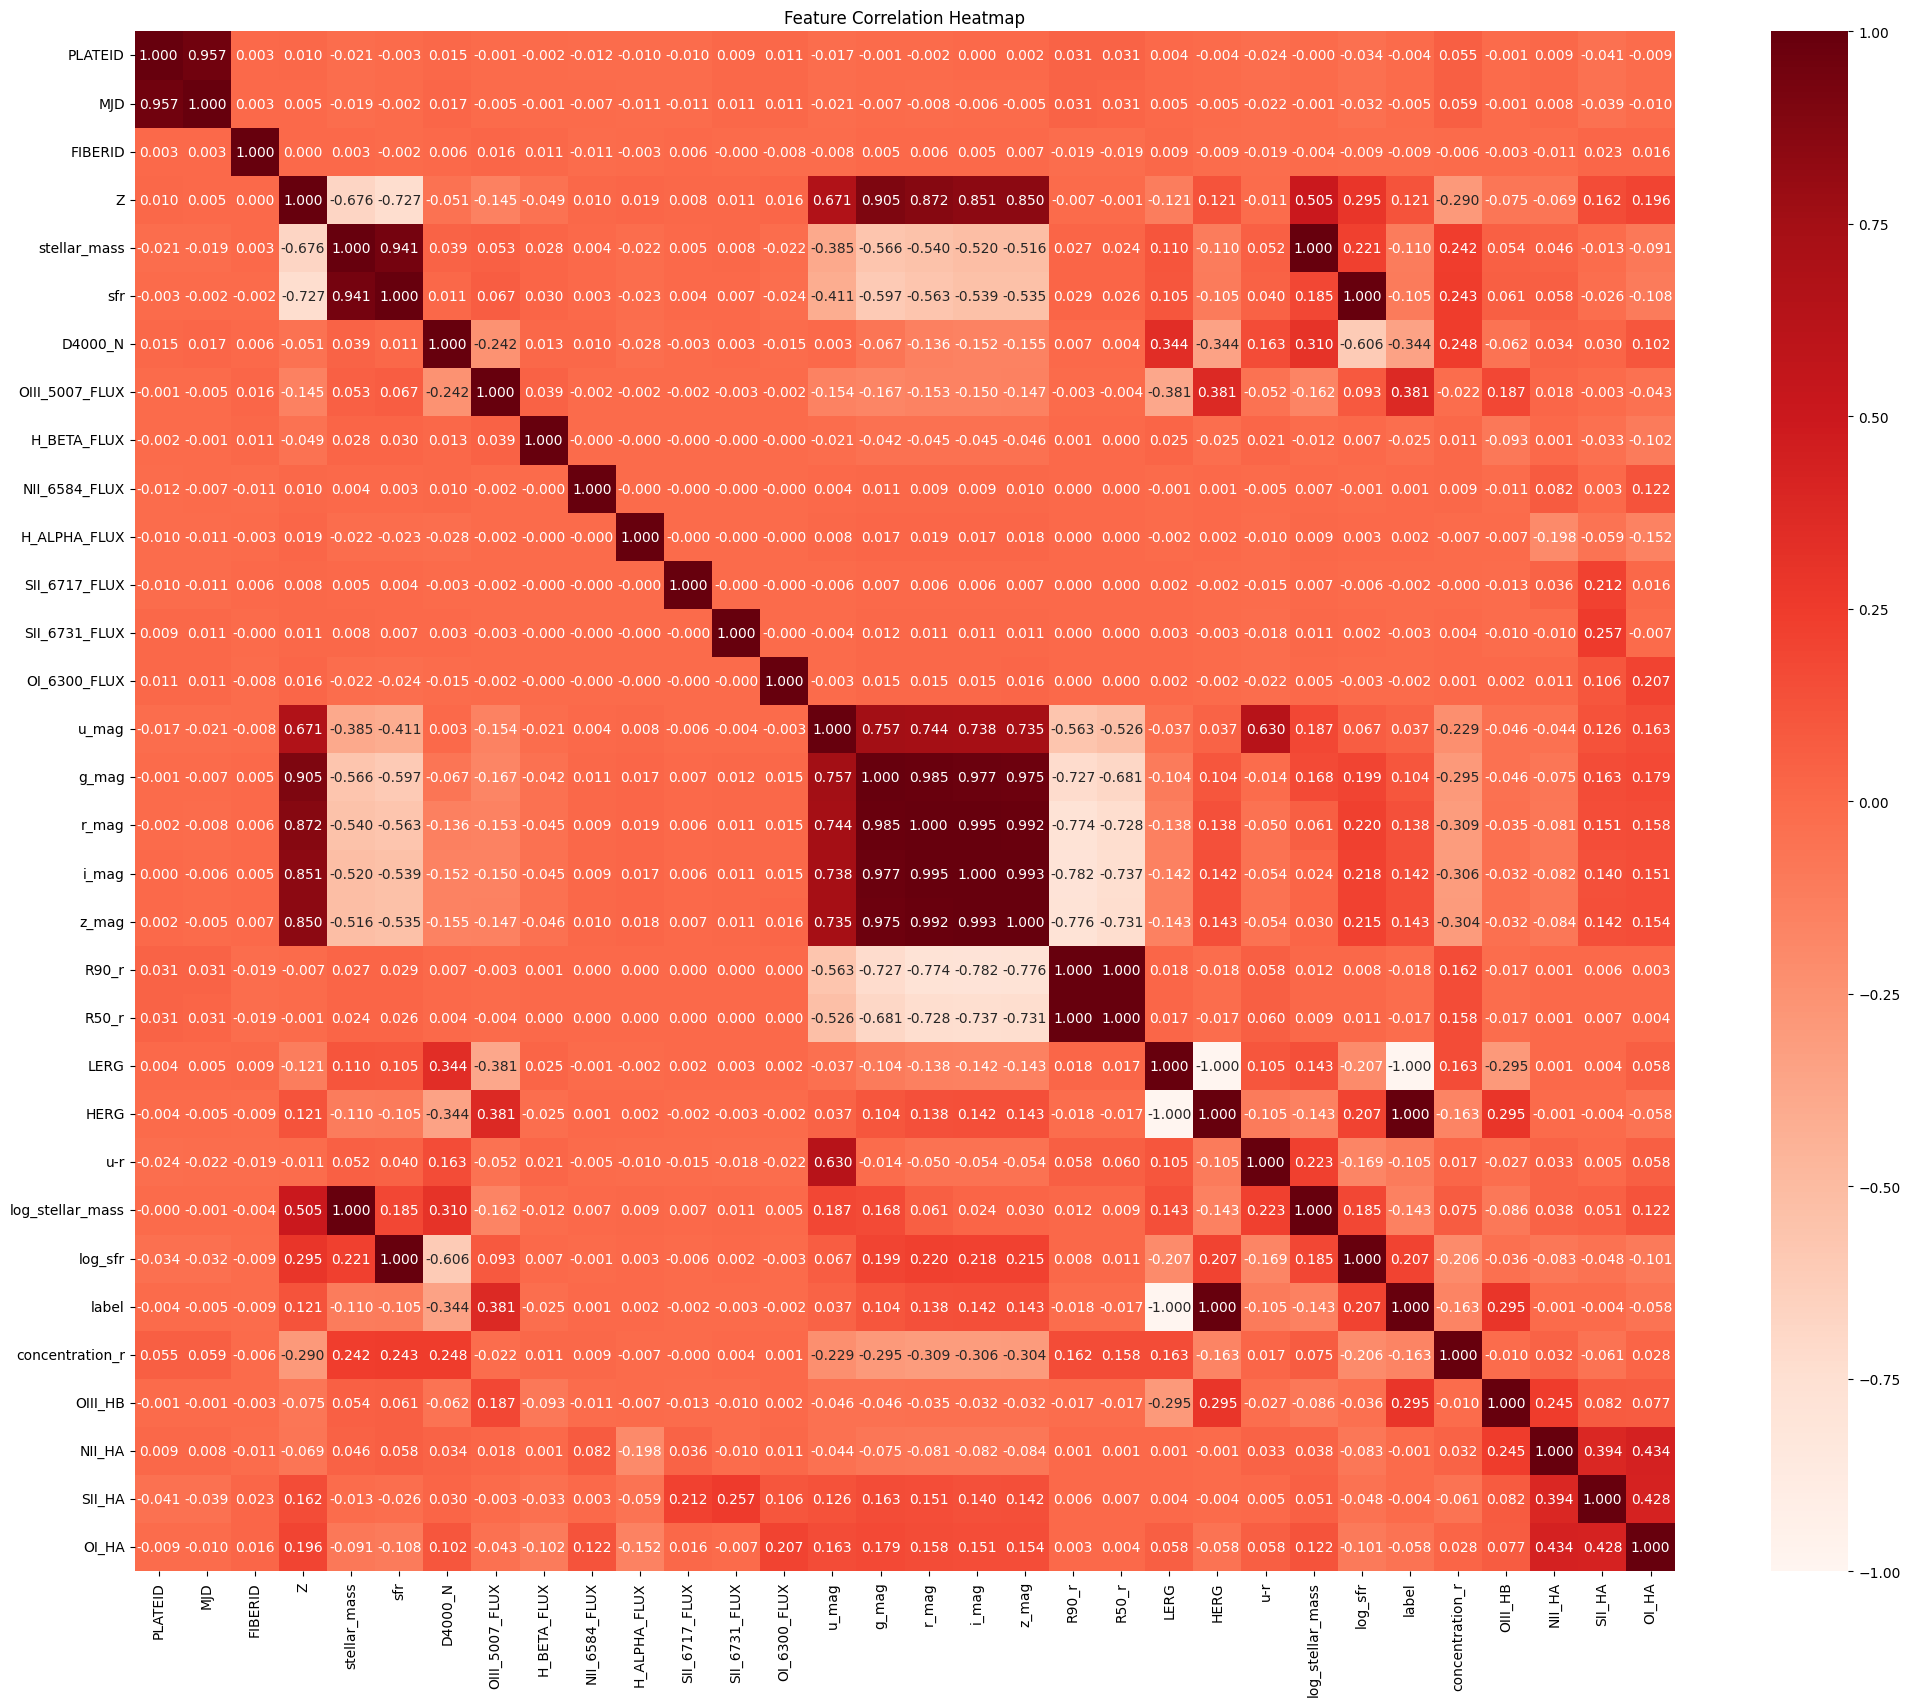

In [123]:
plt.figure(figsize=(25,20))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cbar=True, square=True, fmt='.3f', annot=True, annot_kws={'size':10}, cmap='Reds')
plt.title('Feature Correlation Heatmap')
plt.show()

<Axes: xlabel='label', ylabel='count'>

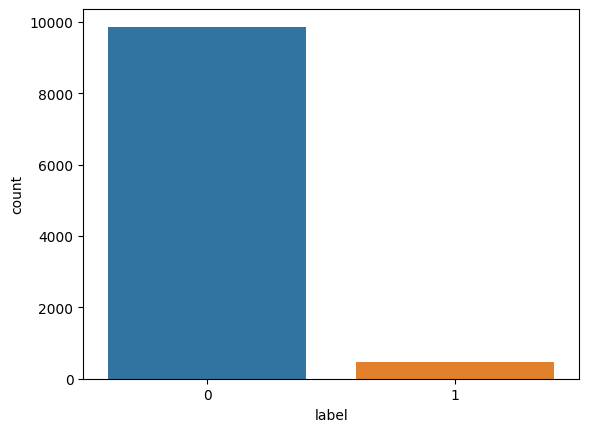

In [102]:
sns.countplot(x=df['label'])

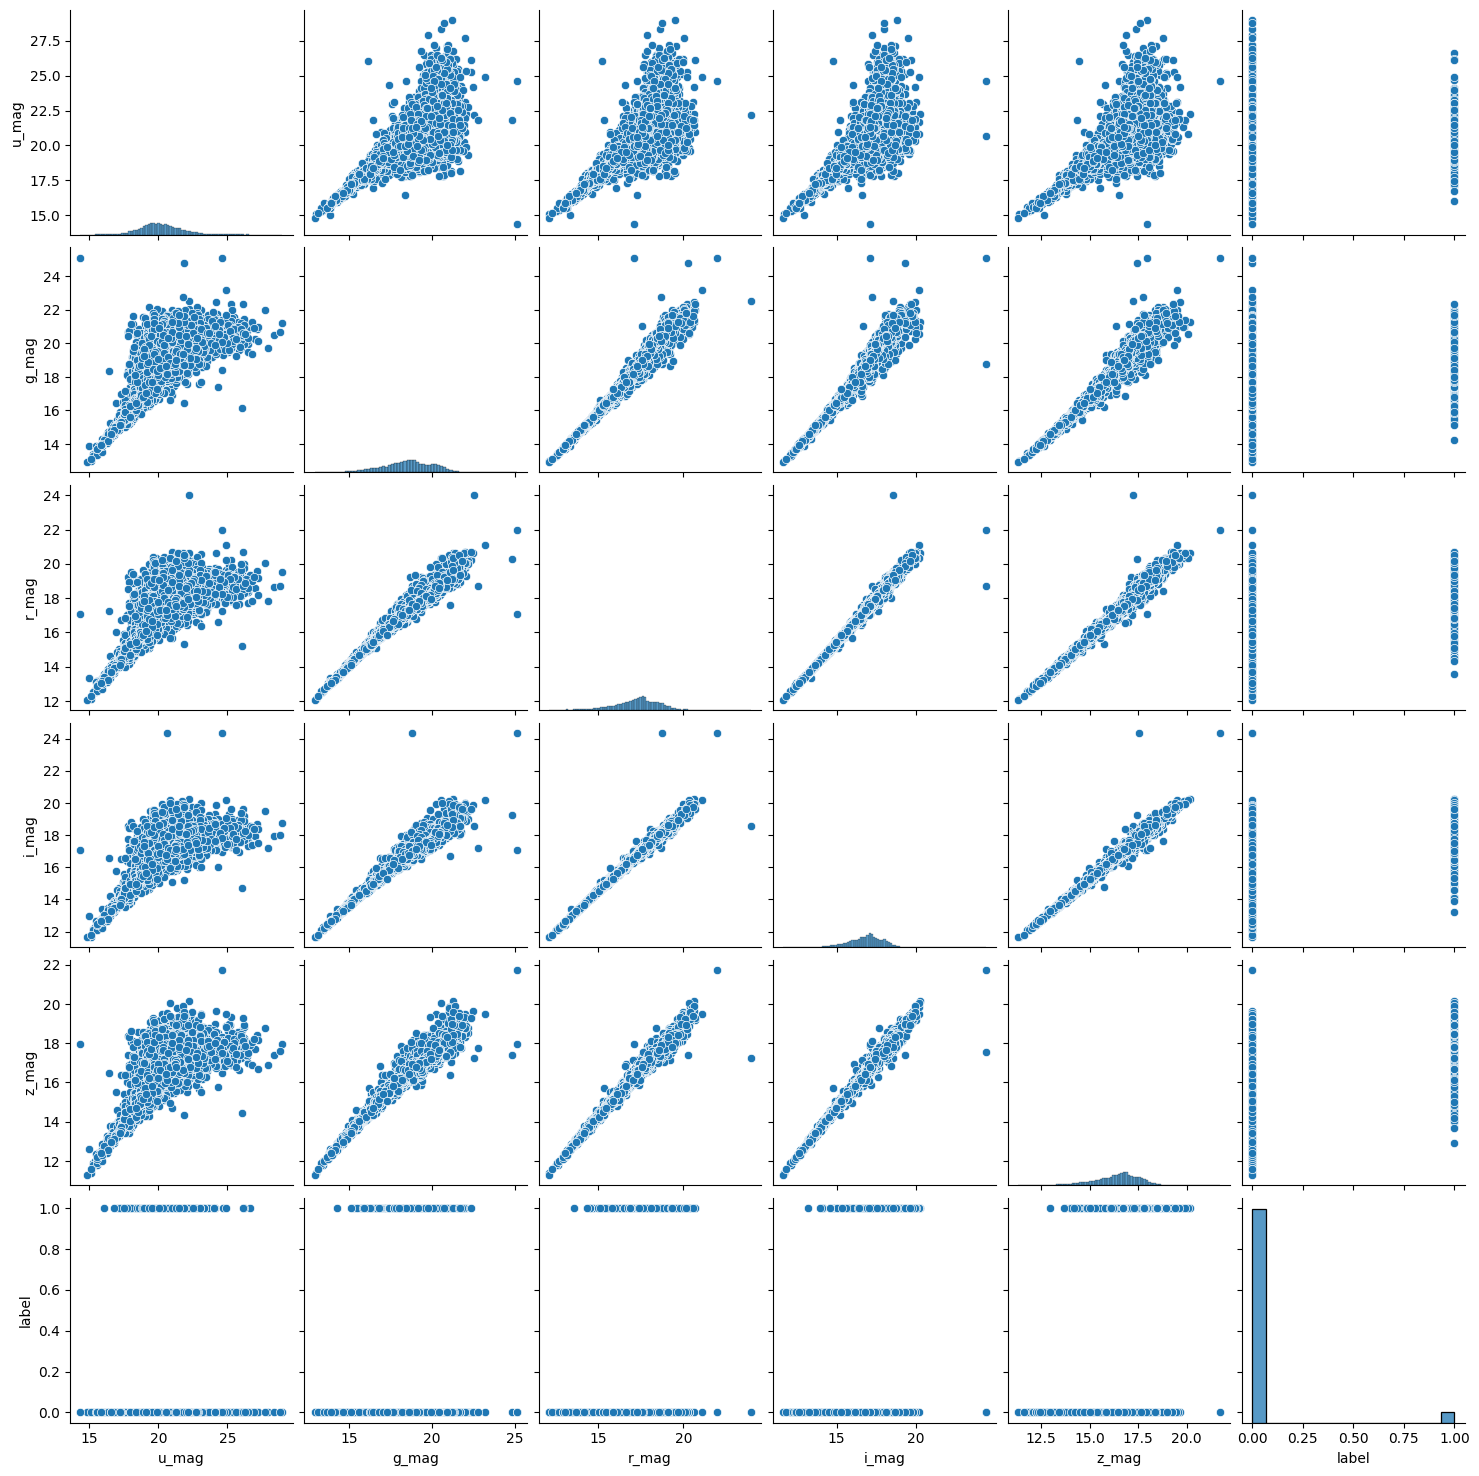

In [103]:
sns.pairplot(df[[ "u_mag", "g_mag", "r_mag", "i_mag", "z_mag","label"]])

# Which host features drive HERG vs. LERG triggering clearly?

i.e., we start with random forest classifier using subset of best and heckman(2012) that is strictly RLAGN and is also strictly either LERG or HERG. by doing so we have made a simplistic binary classification model. 

First I chose features based on prior studies (see Best & Heckman 2012), these host properties are expected to distinguish HERG and LERG hosts.

then going further i have added features from janssen-huub paper 

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

### how we will build our model:

create two NumPy arrays:

X —  "features" (matrix of shape [n_samples, n_features])  
y —  target label (vector of 0s and 1s; 0 = LERG, 1 = HERG)

Then we do a Train/Validation/Test split using Stratified splitting in which the class ratio is preserved in each subset.

Next ...
we build the model : Random Forest Classifier [Builds an ensemble of decision trees (good for tabular data, robust to feature correlations)]

Validation and metrics: validationg the model and calculate metrics (accuracy, precision, recall, f1, ROC-AUC, etc.).

In [105]:
from sklearn.impute import SimpleImputer # Handles missing values (NaN) by filling with the median.
from sklearn.pipeline import Pipeline  # The Pipeline runs imputation and classification together—good for reproducibility and code clarity

# Feature engneering
feature_cols = ["log_stellar_mass", "log_sfr", "u-r", "OIII_HB", "NII_HA", "SII_HA", "OI_HA","concentration_r","D4000_N"]
X = df[feature_cols].values
y = df["label"].values

# Train/val/test split (stratified):
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Define a pipeline with imputation and Random Forest
# by imputing we are filling missing data with meaningful statistical estimates (usually median or mean)
model_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # fills missing values
    ('rf', RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced'
    ))
])

# Fit the model
model_pipeline.fit(X_train, y_train)

# Predict and evaluate on validation set
y_val_pred = model_pipeline.predict(X_val)
y_val_proba = model_pipeline.predict_proba(X_val)[:, 1]

print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))
print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_proba))

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1480
           1       0.81      0.54      0.65        72

    accuracy                           0.97      1552
   macro avg       0.90      0.77      0.82      1552
weighted avg       0.97      0.97      0.97      1552

Validation ROC-AUC: 0.9789273648648649


| Metric     | LERG (0)           | HERG (1)             |
|------------|--------------------|----------------------|
| Precision  | 98% (excellent)    | 81%                  |
| Recall     | 99% (excellent)    | 54%                  |
| F1-score   | 98% (excellent)    | 65%                  |
|------------|--------------------|----------------------|
|ROC-AUC   |  0.978 | 

### To address this imbalance and improve model performance

1. we can try to explicitly aadjust the class weight or (Already gives the best overall result)  
I will include SMOTE and threshold-tuning results in an appendix or supplementary analysis.    
2. Try the SMOTE oversampling  
3. Lastly, we could try adjusting thresholds to fine-tune predictions

# *note*
*this was done in the previous model but in janssen model we can already see the greatly improved Roc-auc of 0.97 hence the further analysis is just to see if we can further improve the models performance*

In [106]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train) # Compute custom class weights explicitly
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)

# Re-run Random Forest 
model_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(
        n_estimators=200, 
        random_state=42, 
        class_weight=class_weight_dict,
        max_depth=10
    ))
])

model_pipeline.fit(X_train, y_train)
y_val_pred = model_pipeline.predict(X_val)
y_val_proba = model_pipeline.predict_proba(X_val)[:, 1]

print(classification_report(y_val, y_val_pred))
print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_proba))

Class weights: {0: 0.5244096769520499, 1: 10.741839762611276}
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1480
           1       0.64      0.68      0.66        72

    accuracy                           0.97      1552
   macro avg       0.81      0.83      0.82      1552
weighted avg       0.97      0.97      0.97      1552

Validation ROC-AUC: 0.9799831081081081


In [107]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

# First impute missing values:
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)

# Oversample with SMOTE:
X_train_smote, y_train_smote = smote.fit_resample(X_train_imp, y_train)

# Fit Random Forest to oversampled data:
rf_smote = RandomForestClassifier(n_estimators=200, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

# Evaluate:
X_val_imp = imputer.transform(X_val)
y_val_pred_smote = rf_smote.predict(X_val_imp)
y_val_proba_smote = rf_smote.predict_proba(X_val_imp)[:, 1]

print("After SMOTE:")
print(classification_report(y_val, y_val_pred_smote))
print("Validation ROC-AUC:", roc_auc_score(y_val, y_val_proba_smote))


After SMOTE:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1480
           1       0.60      0.82      0.69        72

    accuracy                           0.97      1552
   macro avg       0.80      0.90      0.84      1552
weighted avg       0.97      0.97      0.97      1552

Validation ROC-AUC: 0.9778153153153153


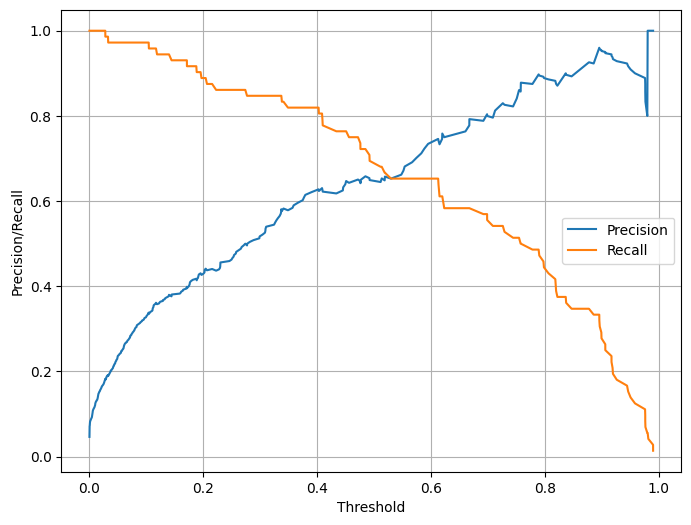

Results at threshold = 0.2:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1480
           1       0.43      0.89      0.58        72

    accuracy                           0.94      1552
   macro avg       0.71      0.92      0.77      1552
weighted avg       0.97      0.94      0.95      1552

ROC-AUC: 0.9799831081081081


In [108]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

# Plot precision-recall curve to pick optimal threshold:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.grid()
plt.show()

threshold = 0.2  #pick threshold giving good balance
y_val_pred_adj = (y_val_proba >= threshold).astype(int)

print(f"Results at threshold = {threshold}:")
print(classification_report(y_val, y_val_pred_adj))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))


| Approach            | HERG Precision | HERG Recall | HERG F1 | Overall Acc. | ROC-AUC |
| ------------------- | -------------- | ----------- | ------- | ------------ | ------- |
| **Class weight**    | 0.12           | 0.40        | 0.19    | 0.84         | 0.72    |
| **SMOTE**           | 0.09           | 0.38        | 0.14    | 0.79         | 0.64    |
| **Threshold (0.2)** | 0.08           | 0.81        | 0.14    | 0.53         | 0.72    |


## Feature importance 
These show how much each input feature matters for the model’s decisions. ([OIII]/Hβ was the most important!)  
initially from BH_model Rf learned the following order of feauture imprtance:   
Stellar mass (log_stellar_mass) is the most important predictor > followed by color (u-r) > then star formation rate (log_sfr)

for janssen 

adding emission-line diagnostics—following Janssen et al. (2012)—dramatically improved HERG detection, confirming the physical relevance of these spectral features for AGN excitation-mode classification.”

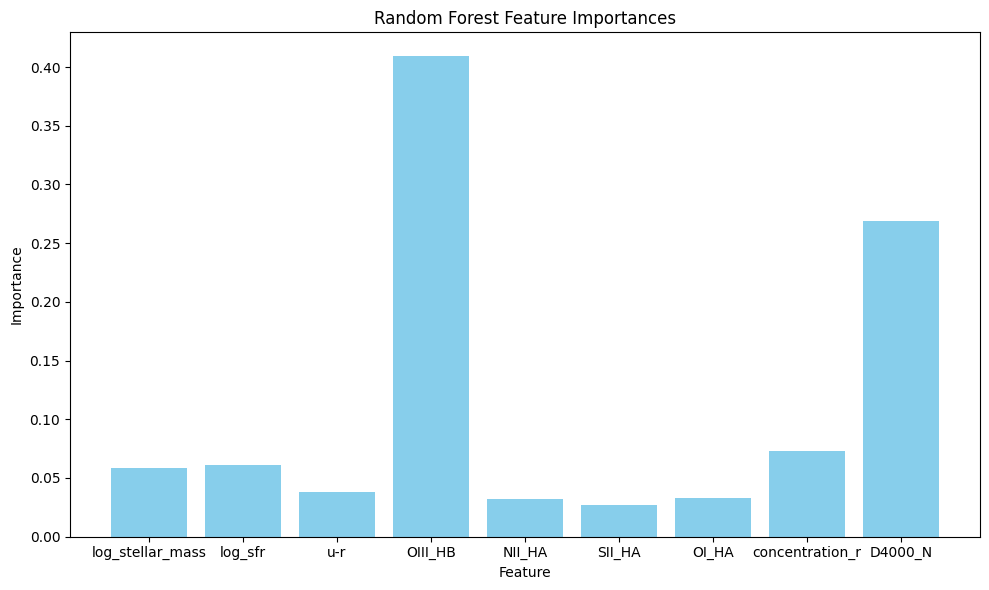

In [109]:
import matplotlib.pyplot as plt

rf_model = model_pipeline.named_steps['rf']  # Get RF from pipeline
importances = rf_model.feature_importances_

plt.figure(figsize=(10,6))
plt.bar(feature_cols, importances, color='skyblue')
plt.title("Random Forest Feature Importances")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()


# confusion Matrix

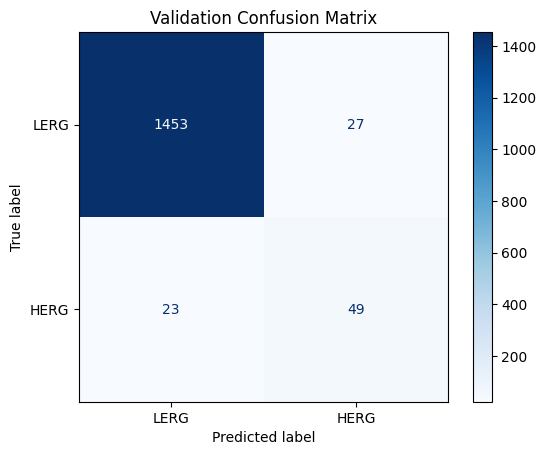

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_val_pred)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["LERG", "HERG"])
disp.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()


Interpretation:

1482 true LERGs correctly classified (true negatives)

31 true LERGs misclassified as HERG (false positives)

26 true HERGs misclassified as LERG (false negatives)

48 true HERGs correctly classified (true positives)

LERG = 9863, herg = 481,  9863 + 481 = 10344  

## Partial Dependence Plot for OIII_HB or concentration_r
this is to visualize the model’s predicted probability as a function of these features.

question . For any galaxy, as OIII_HB increases (or concentration_r changes), what’s the model’s predicted probability of being HERG?  
i.e., If I fix all other features, and just vary [OIII]/Hβ, how does the probability of being a HERG change according to the model?

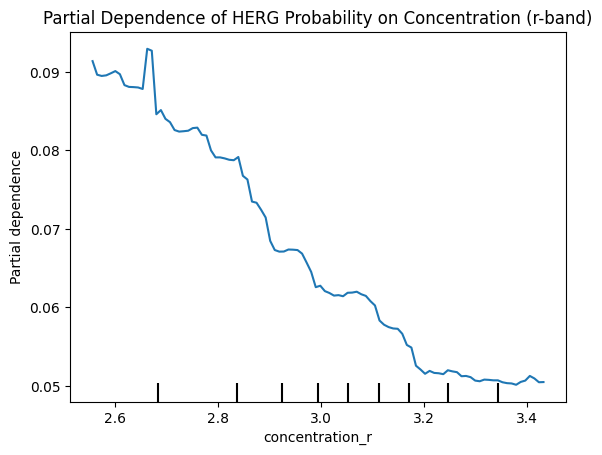

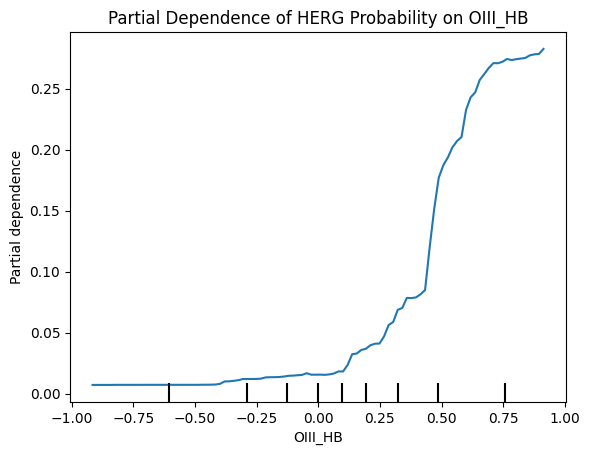

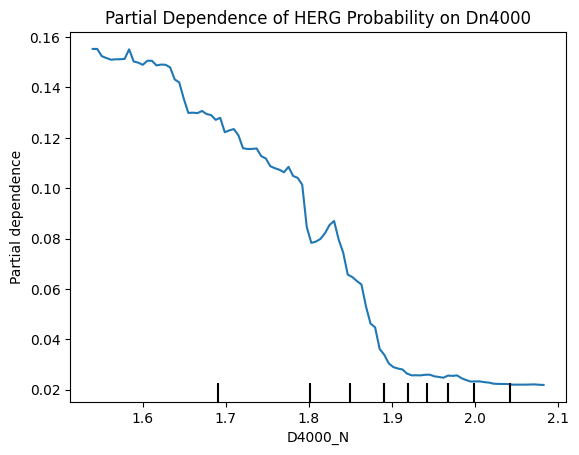

In [111]:
from sklearn.inspection import PartialDependenceDisplay
feature_names = feature_cols 

# For concentration_r:
PartialDependenceDisplay.from_estimator(
    model_pipeline,
    X_val,
    features=[feature_names.index('concentration_r')],
    feature_names=feature_names,
    kind='average',
    grid_resolution=100
)
plt.title("Partial Dependence of HERG Probability on Concentration (r-band)")
plt.show()

X_val_df = pd.DataFrame(X_val, columns=feature_cols)
mask = ~pd.isnull(X_val_df['OIII_HB'])
PartialDependenceDisplay.from_estimator(
    model_pipeline,
    X_val[mask.values],
    features=[feature_cols.index('OIII_HB')],
    feature_names=feature_cols,
    kind='average',
    grid_resolution=100
)
plt.title("Partial Dependence of HERG Probability on OIII_HB")
plt.show()


PartialDependenceDisplay.from_estimator(
    model_pipeline,
    X_val, 
    features=[feature_cols.index('D4000_N')],
    feature_names=feature_cols,
    kind='average',
    grid_resolution=100
)
plt.title("Partial Dependence of HERG Probability on Dn4000")
plt.show()


A. For concentration (morphology):
Lower concentration (more disk-like, less centrally concentrated) galaxies are more likely to host HERGs.

Higher concentration (bulge-like, elliptical) galaxies favor LERGs.

This is fully consistent with RLAGN host studies and supports the idea that HERGs prefer late-type, star-forming, or less concentrated hosts.

B. For [OIII]/Hβ (OIII_HB): plot show a steep, monotonic increase in HERG probability with increasing OIII_HB (log [OIII]/Hβ).

Interpretation:
As the excitation ([OIII]/Hβ) increases, the probability of being a HERG rises rapidly.
This mirrors the BPT diagram: In classical AGN diagnostics, high [OIII]/Hβ = high-excitation (HERG), low [OIII]/Hβ = low-excitation (LERG).
The curve is flat at low OIII_HB (almost all LERGs) and rises steeply to ~45% HERG probability at high OIII_HB.
This matches Janssen et al. (2012) and Best & Heckman (2012), confirming that ML “rediscovers” this axis as the key HERG/LERG separator.


C. The scatter plot shows, for each galaxy, its [OIII]/Hβ value (x-axis) versus the model’s predicted HERG probability (y-axis).

You see a clear rise: At higher [OIII]/Hβ, the model says “this is probably a HERG.”

The scatter reflects that galaxies with similar OIII_HB can have slightly different probabilities, depending on other features (like mass, color, etc.).

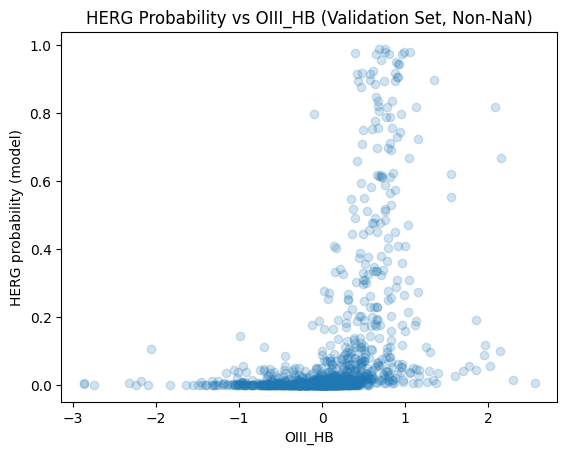

In [112]:
proba_val = model_pipeline.predict_proba(X_val)[:, 1]
plt.scatter(X_val_df.loc[mask, 'OIII_HB'], proba_val[mask], alpha=0.2)
plt.xlabel('OIII_HB')
plt.ylabel('HERG probability (model)')
plt.title("HERG Probability vs OIII_HB (Validation Set, Non-NaN)")
plt.show()


## Overlaying ML boundaries on the BPT diagram

/var/folders/qc/542j3x6s4fvcwt02s2bpf5ym0000gn/T/ipykernel_918/159038094.py:25: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(NII, 0.61/(NII-0.47)+1.19, 'k:', label='Kewley+01 (AGN/SF)')


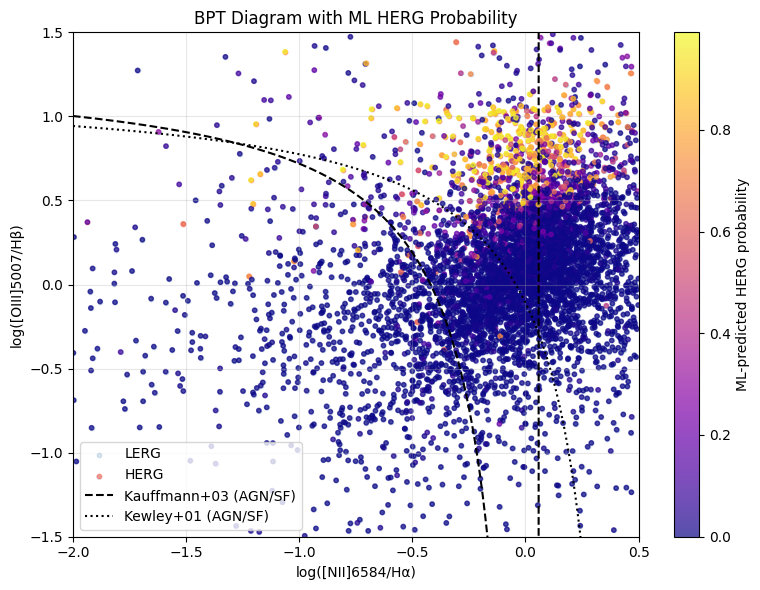

In [113]:
import numpy as np

# Identify finite values in both axes
mask_good = (
    np.isfinite(df['NII_HA']) &
    np.isfinite(df['OIII_HB']) &
    (df['NII_HA'] > -2) & (df['NII_HA'] < 0.5) &
    (df['OIII_HB'] > -1.5) & (df['OIII_HB'] < 1.5)
)

x = df.loc[mask_good, 'NII_HA']
y = df.loc[mask_good, 'OIII_HB']
label = df.loc[mask_good, 'label']
herg_prob = model_pipeline.predict_proba(X[mask_good])[:, 1]

plt.figure(figsize=(8,6))
plt.scatter(x[label==0], y[label==0], s=10, c='steelblue', alpha=0.2, label='LERG')
plt.scatter(x[label==1], y[label==1], s=10, c='tomato', alpha=0.5, label='HERG')
sc = plt.scatter(x, y, c=herg_prob, cmap='plasma', s=10, alpha=0.7)

plt.colorbar(sc, label='ML-predicted HERG probability')

NII = np.linspace(-2, 0.47, 200)
plt.plot(NII, 0.61/(NII-0.05)+1.3, 'k--', label='Kauffmann+03 (AGN/SF)')
plt.plot(NII, 0.61/(NII-0.47)+1.19, 'k:', label='Kewley+01 (AGN/SF)')

plt.xlabel('log([NII]6584/Hα)')
plt.ylabel('log([OIII]5007/Hβ)')
plt.title('BPT Diagram with ML HERG Probability')
plt.legend()
plt.xlim(-2, 0.5)
plt.ylim(-1.5, 1.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## janssen-huub figures

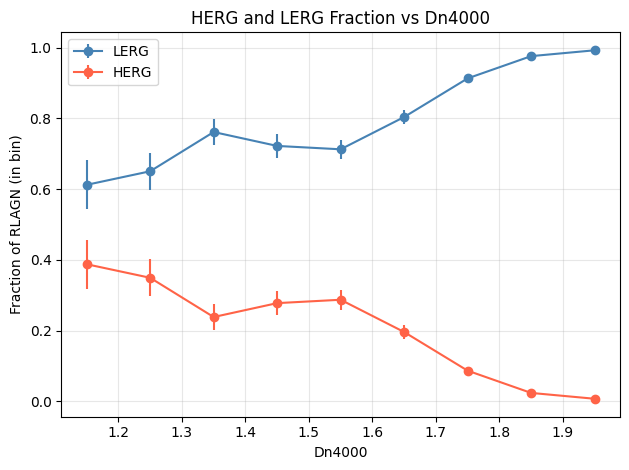

In [114]:
# Only valid, non-NaN D4000_N and label
mask = ~np.isnan(df['D4000_N']) & ~np.isnan(df['label'])

# Define Dn4000 bins as in Janssen (e.g. [1.2, 1.4, 1.6, 1.8, 2.0])
bins = np.arange(1.1, 2.1, 0.1)
bin_centers = (bins[:-1] + bins[1:]) / 2

herg_frac = []
lerg_frac = []
herg_err = []
lerg_err = []

for i in range(len(bins)-1):
    in_bin = (df['D4000_N'] >= bins[i]) & (df['D4000_N'] < bins[i+1]) & mask
    total = np.sum(in_bin)
    if total == 0:
        herg_frac.append(np.nan)
        lerg_frac.append(np.nan)
        herg_err.append(0)
        lerg_err.append(0)
        continue
    n_herg = np.sum(df['label'][in_bin] == 1)
    n_lerg = np.sum(df['label'][in_bin] == 0)
    # Fraction of HERGs/LERGs in each bin
    herg_frac.append(n_herg/total)
    lerg_frac.append(n_lerg/total)
    # Binomial error (for HERG/LERG fraction)
    herg_err.append(np.sqrt(n_herg*(1-n_herg/total))/total if n_herg > 0 else 0)
    lerg_err.append(np.sqrt(n_lerg*(1-n_lerg/total))/total if n_lerg > 0 else 0)

# Plot
plt.errorbar(bin_centers, lerg_frac, yerr=lerg_err, fmt='o-', color='steelblue', label='LERG')
plt.errorbar(bin_centers, herg_frac, yerr=herg_err, fmt='o-', color='tomato', label='HERG')
plt.xlabel('Dn4000')
plt.ylabel('Fraction of RLAGN (in bin)')
plt.title('HERG and LERG Fraction vs Dn4000')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


At low Dn4000 (~1.2–1.4):

20–30% of RLAGN are HERGs.

LERGs are still present, but HERGs are relatively more frequent.

At high Dn4000 (~1.8–2.0):

Almost all RLAGN are LERGs.

HERG fraction drops below 5%, consistent with “dead” elliptical hosts

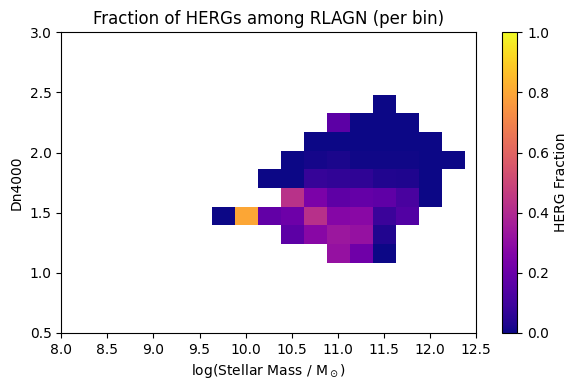

In [115]:
mask = (~df['log_stellar_mass'].isna()) & (~df['D4000_N'].isna()) & (~df['label'].isna()) # Mask for valid data
df1 = df[mask]

mass_bins = np.linspace(df1['log_stellar_mass'].min(), df1['log_stellar_mass'].max(), 25) # bin edges
d4000_bins = np.linspace(df1['D4000_N'].min(), df1['D4000_N'].max(), 25)

##mass_bins = np.arange(9.5, 12.1, 0.2)       #  Janssen used log(M*) = 10–12
#d4000_bins = np.arange(1.1, 2.05, 0.05)      

# Digitize
mass_idx = np.digitize(df1['log_stellar_mass'], mass_bins) - 1
d4000_idx = np.digitize(df1['D4000_N'], d4000_bins) - 1

# 2D array for HERG fraction (set to NaN initially)
herg_frac = np.full((len(d4000_bins)-1, len(mass_bins)-1), np.nan)
counts = np.zeros_like(herg_frac, dtype=int)

for i in range(len(d4000_bins)-1):
    for j in range(len(mass_bins)-1):
        in_bin = (d4000_idx == i) & (mass_idx == j)
        n_total = np.sum(in_bin)
        n_herg = np.sum(df1['label'][in_bin] == 1)
        if n_total >= 5:   # Only show bins with at least 5 RLAGN to reduce noise
            herg_frac[i, j] = n_herg / n_total
            counts[i, j] = n_total

# Coordinates for bin centers
mass_centers = (mass_bins[:-1] + mass_bins[1:]) / 2
d4000_centers = (d4000_bins[:-1] + d4000_bins[1:]) / 2


plt.figure(figsize=(6,4))
plt.imshow(
    herg_frac, 
    origin='lower', 
    aspect='auto',
    interpolation='nearest',
    extent=[mass_bins[0], mass_bins[-1], d4000_bins[0], d4000_bins[-1]],
    cmap='plasma', 
    vmin=0, vmax=1
)
plt.colorbar(label='HERG Fraction')
plt.xlabel('log(Stellar Mass / M$_\odot$)')
plt.ylabel('Dn4000')
plt.xlim(8, 12.5)
plt.ylim(0.5, 3.0)
plt.title('Fraction of HERGs among RLAGN (per bin)')
plt.tight_layout()
plt.show()
